<a href="https://colab.research.google.com/github/Paras-Shirvale/Quiz-2/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install augly

In [10]:
!pip install --upgrade augly -q
!pip install nlpaug -q

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [12]:
# Specify the folder where images are stored; update this path as needed
# cats = "test\cats"
# dogs = "test\dogs"

cats = "/content/drive/MyDrive/test/cats"
dogs = "/content/drive/MyDrive/test/dogs"

# List image files with .jpg extension
cats_files = [f for f in os.listdir(cats) if f.lower().endswith('.jpg')]
dogs_files = [f for f in os.listdir(dogs) if f.lower().endswith('.jpg')]

# Create a dataframe from the list of image filenames
df_cats = pd.DataFrame(cats_files, columns=['cats_filename'])
df_cats['cats_filepath'] = df_cats['cats_filename'].apply(lambda x: os.path.join(cats, x))
df_cats['cats_filename'] = df_cats['cats_filename'].str.slice(0, -4)
df_cats['cats_pixels'] = df_cats['cats_filepath'].apply(lambda x: Image.open(x))

df_dogs = pd.DataFrame(dogs_files, columns=['dogs_filename'])
df_dogs['dogs_filepath'] = df_dogs['dogs_filename'].apply(lambda x: os.path.join(dogs, x))
df_dogs['dogs_filename'] = df_dogs['dogs_filename'].str.slice(0, -4)
df_dogs['dogs_pixels'] = df_dogs['dogs_filepath'].apply(lambda x: Image.open(x))

# Sorted the Dataframe by filename
df_cats = df_cats.sort_values(by='cats_filename', ascending=True)
df_dogs = df_dogs.sort_values(by='dogs_filename', ascending=True)

In [13]:
# Split df_cats and df_dogs into training and test sets (80% train, 20% test)
df_cats_train, df_cats_test = train_test_split(df_cats, test_size=0.2, random_state=42)
df_dogs_train, df_dogs_test = train_test_split(df_dogs, test_size=0.2, random_state=42)

print("df_cats_train shape:", df_cats_train.shape)
print("df_cats_test shape:", df_cats_test.shape)
print("df_dogs_train shape:", df_dogs_train.shape)
print("df_dogs_test shape:", df_dogs_test.shape)

df_cats_train shape: (56, 3)
df_cats_test shape: (14, 3)
df_dogs_train shape: (56, 3)
df_dogs_test shape: (14, 3)


In [14]:
# Specify the save directory
save_dir = "/"

# Use the save_dir variable correctly in the file path
df_cats_train.to_csv(f'{save_dir}/cats_train.csv', index=False)
df_dogs_train.to_csv(f'{save_dir}/dogs_train.csv', index=False)
df_cats_test.to_csv(f'{save_dir}/cats_test.csv', index=False)
df_dogs_test.to_csv(f'{save_dir}/dogs_test.csv', index=False)

In [15]:
train_cats_count = len(df_cats_train)
test_cats_count = len(df_cats_test)
train_dogs_count = len(df_dogs_train)
test_dogs_count = len(df_dogs_test)

print("Number of training cats:", train_cats_count)
print("Number of test cats:", test_cats_count)
print("Number of training dogs:", train_dogs_count)
print("Number of test dogs:", test_dogs_count)

Number of training cats: 56
Number of test cats: 14
Number of training dogs: 56
Number of test dogs: 14


In [16]:
import random
import augly.image as imaugs
from PIL import Image

In [20]:
# Function to perform random data augmentation
def random_augmentations(input_image: Image.Image):
    # List of augmentations with their functions and relevant parameters
    augmentations = [
        ("rotate", imaugs.rotate, {"degrees": 45}),  # Rotate with a degree parameter
        ("clip_image_size", imaugs.clip_image_size, {"min_resolution": 256, "max_resolution": 1024}),  # Clip image size
        ("grayscale", imaugs.grayscale, {"mode": "luminosity"}),  # Convert to grayscale (luminosity mode)
        ("crop", imaugs.crop, {"x1": 0.1, "y1": 0.1, "x2": 0.9, "y2": 0.9}),  # Crop the image
        ("hflip", imaugs.hflip, {}),  # Horizontal flip
        ("vflip", imaugs.vflip, {}),  # Vertical flip
        ("random_noise", imaugs.random_noise, {"mean": 0, "var": 0.05}),  # Add random noise
        ("skew", imaugs.skew, {}),  # Skew the image
        ("blur", imaugs.blur, {"radius": 5.0}),  # Apply blur with a radius
        ("color_jitter", imaugs.color_jitter, {"brightness_factor": 1.2, "contrast_factor": 1.5}),  # Apply color jitter
    ]

    # Randomly select the augmentations to apply
    selected_augmentations = random.sample(augmentations, 2)

    # Apply selected augmentations to the input image
    augmented_image = input_image
    applied_augs = []  # List to keep track of the applied augmentations
    for aug_name, aug_func, params in selected_augmentations:
        try:
            augmented_image = aug_func(augmented_image, **params)  # Apply the function with its parameters
            applied_augs.append(aug_name)  # Track the applied augmentation name
        except Exception as e:
            print(f"Error applying augmentation {aug_name}: {e}")
            continue  # Skip this augmentation if there is an error

    return augmented_image, applied_augs

In [21]:
# Extract image file paths from the 'filepath' column
cats_train_image_paths = df_cats_train['cats_filepath'].tolist()  # List of image file paths
cats_train_image_names = df_cats_train['cats_filename'].tolist()  # List of image names
dogs_train_image_paths = df_dogs_train['dogs_filepath'].tolist()  # List of image file paths
dogs_train_image_names = df_dogs_train['dogs_filename'].tolist()  # List of image names

In [22]:
# Function to perform augmentations and generate the new dataset
def augment_train_set(train_image_paths, train_image_names, save_dir):
    augmented_images = []  # List to store augmented images

    # Create main folder and subfolders for cats and dogs if they don't exist
    cats_folder = os.path.join(save_dir, "augmented_cats")
    dogs_folder = os.path.join(save_dir, "augmented_dogs")

    # Loop through the original train image paths and augment them
    for idx, image_path in enumerate(train_image_paths):
        # Load the image from the file path
        img = Image.open(image_path)
        image_name = train_image_names[idx]  # Get the image name

        # Augment the image 3 times in a sequence: crop -> rotate -> blur
        augmented_img_1, augs_1 = random_augmentations(img)  # First augmentated Image
        # print(f"{image_name} image Augmented with the augmentations {', '.join(augs_1)}")
        augmented_img_2, augs_2 = random_augmentations(img)  # Second augmentated Image
        # print(f"{image_name} image Augmented with the augmentations {', '.join(augs_2)}")

        augmented_images.extend([augmented_img_1, augmented_img_2])  # Add augmented images

    # Determine the subfolder based on the image's name (e.g., if it's a cat or dog image)
        if 'cat' in image_name.lower():  # Assuming the image name contains 'cat' for cat images
            save_folder = cats_folder
        elif 'dog' in image_name.lower():  # Assuming the image name contains 'dog' for dog images
            save_folder = dogs_folder
        else:
            save_folder = os.path.join(save_dir, "augmented_others")  # For other images, create a generic folder

        # Ensure the subfolder exists
        os.makedirs(save_folder, exist_ok=True)

        # Save the augmented images with new names
        augmented_img_1.save(os.path.join(save_folder, f"{image_name}_augmented_1.jpg"))
        augmented_img_2.save(os.path.join(save_folder, f"{image_name}_augmented_2.jpg"))

    # The augmented images should be twice the number of original train set images
    return augmented_images

In [23]:
# Augment the training set
print("Performing Augmentations on Cats Images.-----")
augmented_cats_train_set = augment_train_set(cats_train_image_paths, cats_train_image_names, save_dir)
print("Performing Augmentations on Dogs Images.-----")
augmented_dogs_train_set = augment_train_set(dogs_train_image_paths, dogs_train_image_names, save_dir)

# Print the number of augmented images
print(f"Number of augmented images: {len(augmented_cats_train_set) , len(augmented_dogs_train_set)}")
print(augmented_cats_train_set)
print(augmented_dogs_train_set)

Performing Augmentations on Cats Images.-----
Performing Augmentations on Dogs Images.-----
Number of augmented images: (112, 112)
[<PIL.Image.Image image mode=RGB size=500x281 at 0x7E4E8B708ED0>, <PIL.Image.Image image mode=RGB size=500x281 at 0x7E4EC014F390>, <PIL.Image.Image image mode=RGB size=32x32 at 0x7E4E8BC54ED0>, <PIL.Image.Image image mode=RGB size=480x480 at 0x7E4E8AF61B90>, <PIL.Image.Image image mode=RGB size=44x23 at 0x7E4E8AAAAE50>, <PIL.Image.Image image mode=RGB size=1050x549 at 0x7E4E8AAAB950>, <PIL.Image.Image image mode=RGB size=39x26 at 0x7E4E8AAB66D0>, <PIL.Image.Image image mode=RGB size=1200x801 at 0x7E4E8F27DE10>, <PIL.Image.Image image mode=RGB size=353x353 at 0x7E4E8A49B950>, <PIL.Image.Image image mode=RGB size=31x32 at 0x7E4E8AAA88D0>, <PIL.Image.Image image mode=RGB size=56x18 at 0x7E4E8AADE350>, <PIL.Image.Image image mode=RGB size=2000x640 at 0x7E4E8A6692D0>, <PIL.Image.Image image mode=RGB size=300x168 at 0x7E4E8AAB7350>, <PIL.Image.Image image mode=RG

Original Cat Images:


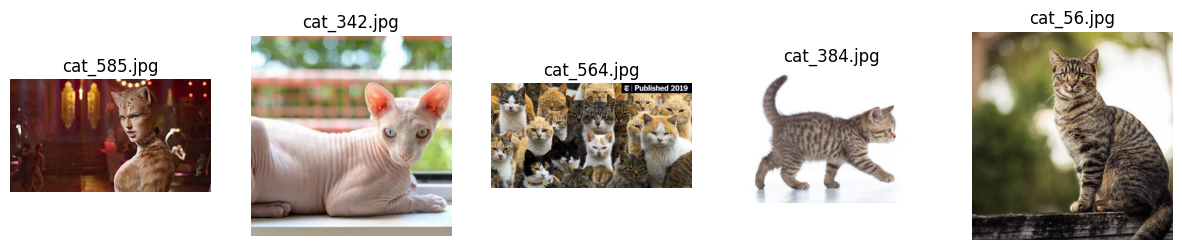


Augmented Cat Images:


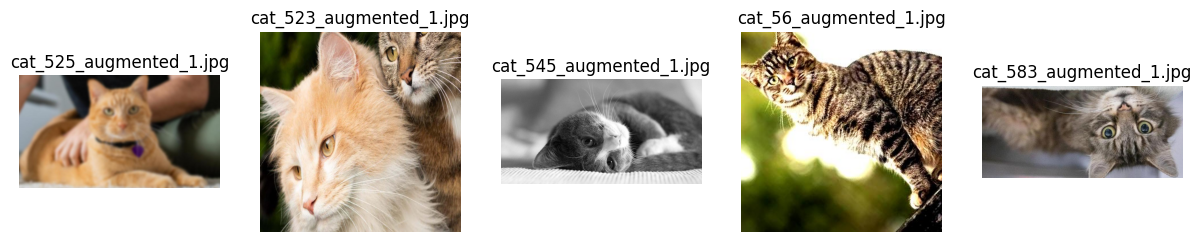


Original Dog Images:


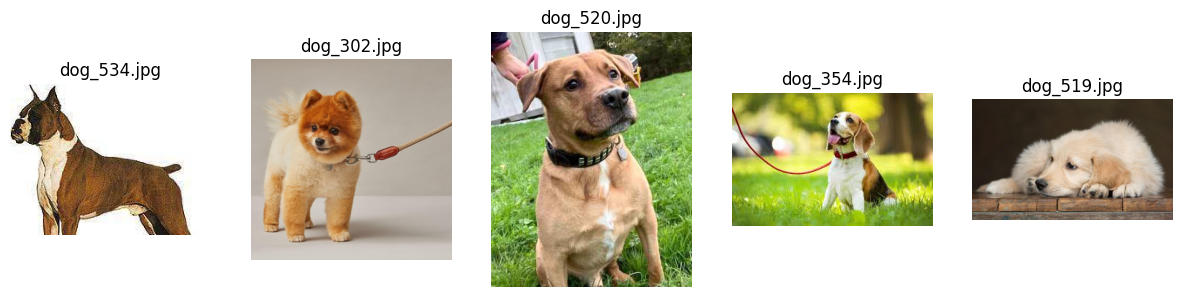


Augmented Dog Images:


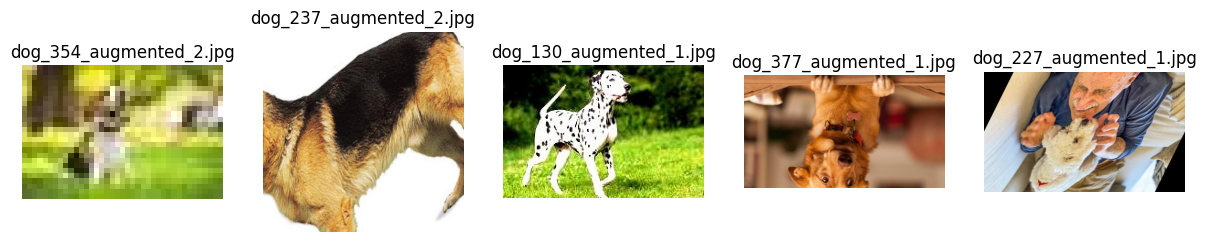

In [25]:
# prompt: Show original images and augmented images

import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the directories for augmented images
augmented_cats_dir = os.path.join(save_dir, "augmented_cats")
augmented_dogs_dir = os.path.join(save_dir, "augmented_dogs")

# Function to display images
def display_images(image_paths, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_path in enumerate(image_paths[:num_images]):
        try:
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(os.path.basename(image_path))
        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
            continue
    plt.show()

# Display original cat images
print("Original Cat Images:")
display_images(df_cats_train['cats_filepath'].tolist())

# Display augmented cat images
print("\nAugmented Cat Images:")
augmented_cats = [os.path.join(augmented_cats_dir, f) for f in os.listdir(augmented_cats_dir) if f.endswith('.jpg')]
display_images(augmented_cats)


# Display original dog images
print("\nOriginal Dog Images:")
display_images(df_dogs_train['dogs_filepath'].tolist())

# Display augmented dog images
print("\nAugmented Dog Images:")
augmented_dogs = [os.path.join(augmented_dogs_dir, f) for f in os.listdir(augmented_dogs_dir) if f.endswith('.jpg')]
display_images(augmented_dogs)
